In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from scipy.stats import skew, kurtosis

torch.cuda.empty_cache()
# imports of custom blocks for model, data generation
from Ferret.ImplicitAm import ImplicitAmBre, ImplicitAmBer
from models import *
from create_plots import *
from utils import AmericanPutData, get_prices_put
from utils import S, T, K, RISK_FREE, SIGMA, S_MAX

## Put Option

### Content: 
1. **Generating Data**
2. **Training on Generated Data, Testing Both on Generated and Real Data**
3. **Training on Real Data, Testing on Real Data**
4. **Mixture of Data (70/30, 50/50), Testing on Real Data**


In [2]:
put_data = AmericanPutData(t_range=T, S_range=S, K=K, r=RISK_FREE, sigma=SIGMA)
# N_ivp - IVP points
# N_bvp - both BVP1 and BVP2 points
# N_col - colocation points
X = put_data.initialize_data(N_ivp=1000, N_bvp=3000, N_col=6000, is_call=False)
option = ImplicitAmBer(
    S[0],
    K,
    RISK_FREE,
    T[1],
    SIGMA,
    S_MAX,
    M=400,  # S
    N=365 * 3,  # t
    is_call=False,
)
option.price()
option_fde_prices = option.grid
data = get_prices_put(X, option_fde_prices, generated=True)
df = pd.DataFrame(
    data=data,
    columns=[
        "TimeToExp",
        "UnderlyingPrice",
        "TargetPrice",
        "OpenInterest",
        "Delta",
        "Gamma",
        "Theta",
        "Vega",
        "BSAprox",
    ],
)
df[["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]] = df[
    ["TimeToExp", "UnderlyingPrice", "TargetPrice", "BSAprox"]
].round(2)
df["OpenInterest"] = df["OpenInterest"].round(0)
df.to_csv("../train_data/generated_put.csv")

(10000, 8)


In [2]:
df = pd.read_csv("../train_data/generated_put.csv", index_col=0)
df.head()

,TimeToExp,UnderlyingPrice,TargetPrice,OpenInterest,Delta,Gamma,Theta,Vega,BSAprox
0,827.0,138.66,39.12,133.0,-0.876502,0.052474,-4.578248,15.334991,0.00
1,1045.0,113.58,45.38,228.0,-0.118852,0.002001,-7.851140,3.742773,6.48
2,395.0,194.28,27.86,937.0,-0.756109,0.000596,-1.044538,0.431675,0.00
3,563.0,112.40,45.66,109.0,-0.196355,0.012452,-4.211471,12.599267,7.64
4,980.0,145.38,37.53,72.0,-0.417402,0.012488,-0.112282,7.536177,0.00


Describe:
count    10000.000000
mean        38.778089
std         32.927976
min          0.000000
25%          0.000000
50%         37.310000
75%         55.310000
max        120.000000
Name: TargetPrice, dtype: float64

Skewness: 0.7879415236679352
Kurtosis: 0.4289552629526088


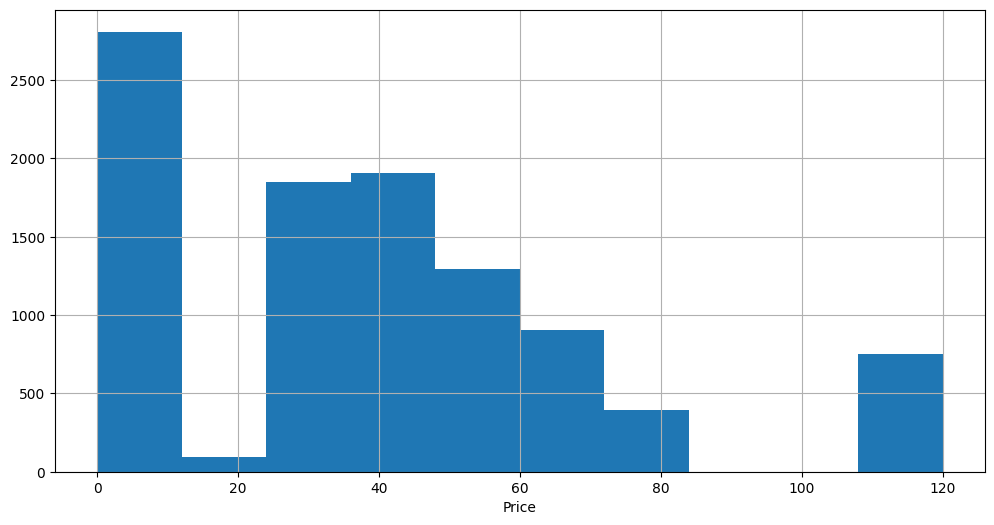

In [9]:
analyze_series(df.TargetPrice)

In [4]:
# Check for ITM and OTM
print(f"ITM count:{np.sum(df.UnderlyingPrice < K)}")
print(f"OTM count:{np.sum(df.UnderlyingPrice >= K)}")

ITM count:4272
OTM count:5728


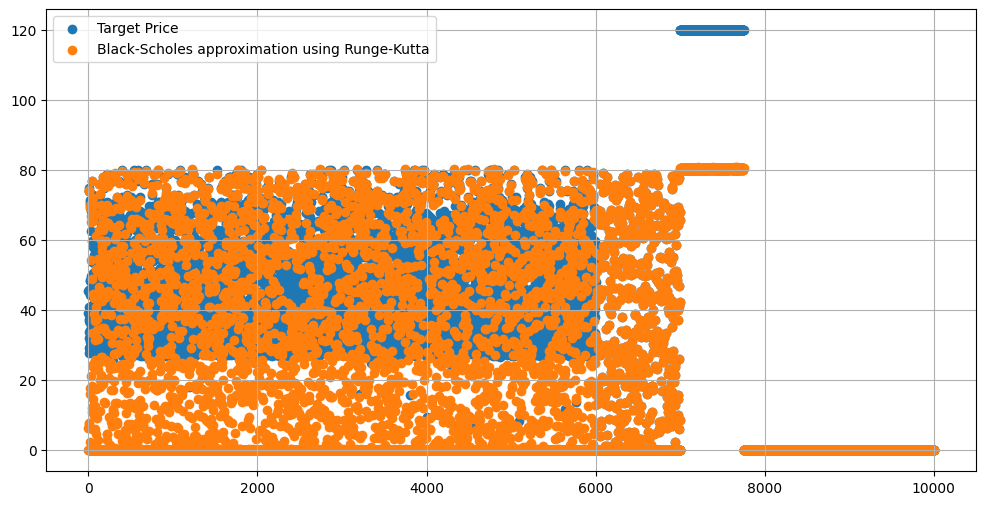

In [6]:
plt.figure(figsize=(12, 6))
plt.scatter(
    x=np.arange(1, len(df.TargetPrice) + 1, 1), y=df.TargetPrice, label="Target Price"
)
plt.scatter(x=np.arange(1, len(df.BSAprox) + 1, 1), y=df.BSAprox, label="Black-Scholes approximation using Runge-Kutta")
plt.legend()
plt.grid(True)
plt.show()

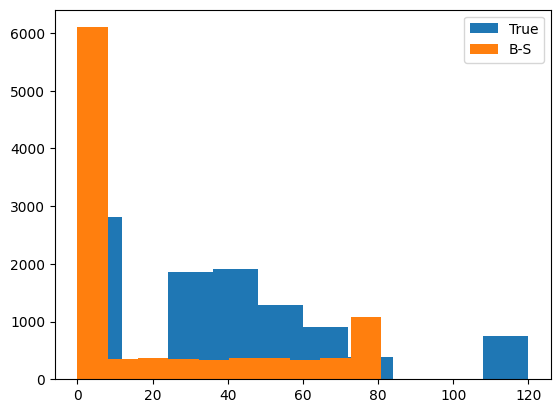

In [6]:
plt.hist(df.TargetPrice, label="True")
plt.hist(df.BSAprox, label="B-S")
plt.legend()
plt.show()

In [4]:
# # adding BSAprox column to real data
# # Run it once, only if u dont have saved df
# df_real = pd.read_csv("../train_data/put_df.csv", index_col=0)
# df_real = get_prices_put(df_real.to_numpy(), generated=False)
# df_real = pd.DataFrame(
#     data=df_real,
#     columns=[
#         [
#             "UnderlyingPrice",
#             "Type",
#             "Strike",
#             "OpenInterest",
#             "IV",
#             "Delta",
#             "Gamma",
#             "Theta",
#             "Vega",
#             "Time",
#             "TargetPrice",
#             "BSAprox",
#         ]
#     ],
# )
# df_real["BSAprox"] = df_real["BSAprox"].round(2)
# df_real.to_csv("../train_data/put_df_with_approx.csv")
# df_real.head()

In [2]:
df_real = pd.read_csv("../train_data/put_df_with_approx.csv", index_col=0)
df_real.head()

,UnderlyingPrice,Type,Strike,OpenInterest,IV,Delta,Gamma,Theta,Vega,Time,TargetPrice,BSAprox
0,71.11,put,55.0,22,0.3314,-0.0004,0.0003,-0.0747,0.0253,21,0.02,0.0
1,71.11,put,60.0,118,0.3314,-0.0130,0.0060,-1.6451,0.5604,21,0.04,0.0
2,71.11,put,62.5,2026,0.3314,-0.0441,0.0168,-4.5773,1.5638,21,0.11,0.0
3,71.11,put,65.0,443,0.2918,-0.0873,0.0324,-6.8317,2.6647,21,0.20,0.0
4,71.11,put,67.5,165,0.2675,-0.1902,0.0605,-10.6215,4.5580,21,0.48,0.0


Describe:
count    223217.000000
mean          9.203034
std          20.484802
min           0.000000
25%           0.000000
50%           0.000000
75%          10.390000
max         600.720000
Name: BSAprox, dtype: float64

Skewness: 6.657008389112579
Kurtosis: 90.22743557230235


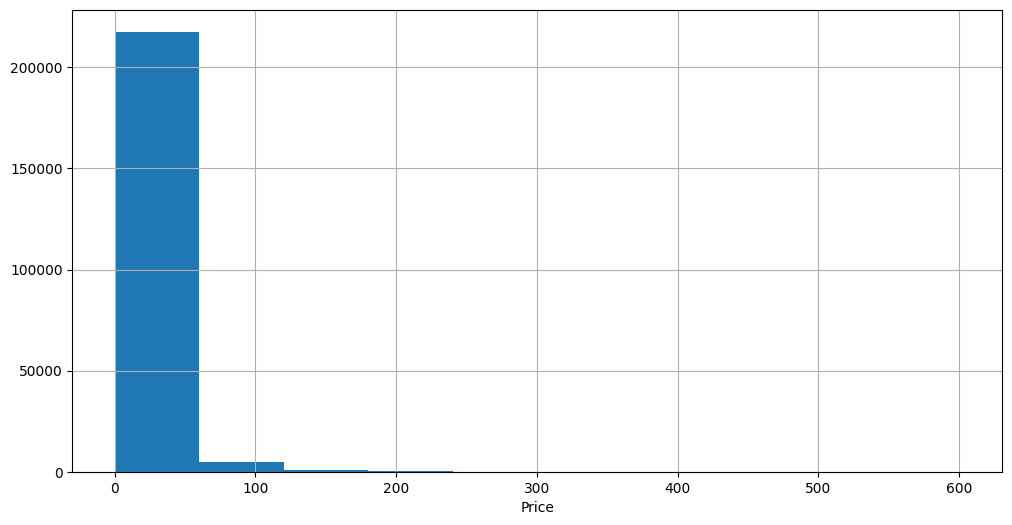

In [8]:
analyze_series(df_real.BSAprox)

In [3]:

# hyperparams for training
N_EPOCH = 20
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 8e-5
HIDDEN_LAYER = 28
HIDDEN_WIDTH = 64
EXPERIMENT_NAME = "exp_put_11_gen"
MODEL_TYPE = AmericanPut_gated3
experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
os.makedirs(experiment_dir, exist_ok=True)

In [4]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)
# torch.set_default_device(DEVICE)
logging.info(f"Running on device={DEVICE}")

cuda


In [6]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [7]:
# df = df_real.sample(n=20000, random_state=15)
df_train, df_val = train_test_split(df, test_size=0.2)
print(df_train.shape)
print(df_val.shape)

(8000, 9)
(2000, 9)


Describe:
count    8000.000000
mean       18.710091
std        16.862430
min        -0.690000
25%         0.000000
50%        20.280000
75%        35.380000
max        43.670000
dtype: float64

Skewness: 0.03355964613496692
Kurtosis: -1.7432346282851796


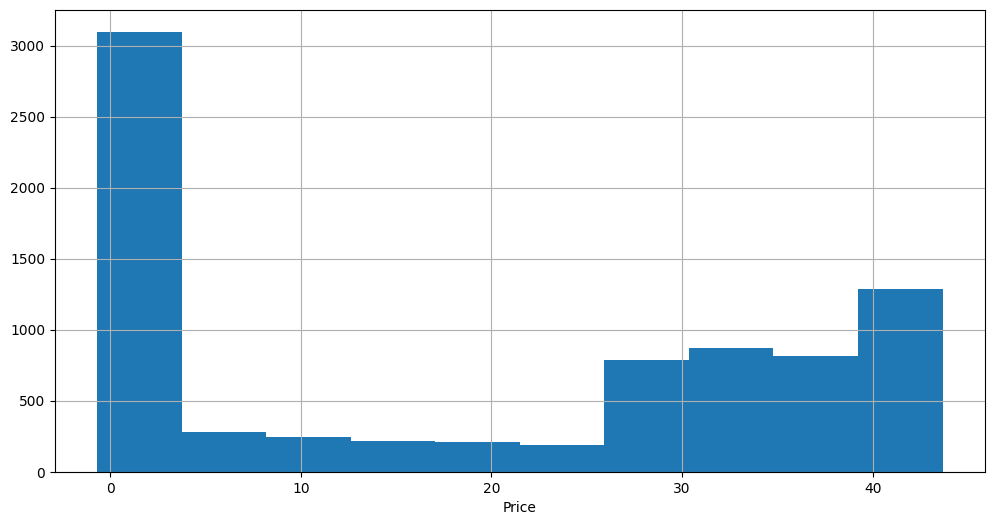

Describe:
count    2000.000000
mean       18.410435
std        16.849013
min        -0.730000
25%         0.000000
50%        18.860000
75%        35.145000
max        43.710000
dtype: float64

Skewness: 0.06256759929666944
Kurtosis: -1.7411420299196783


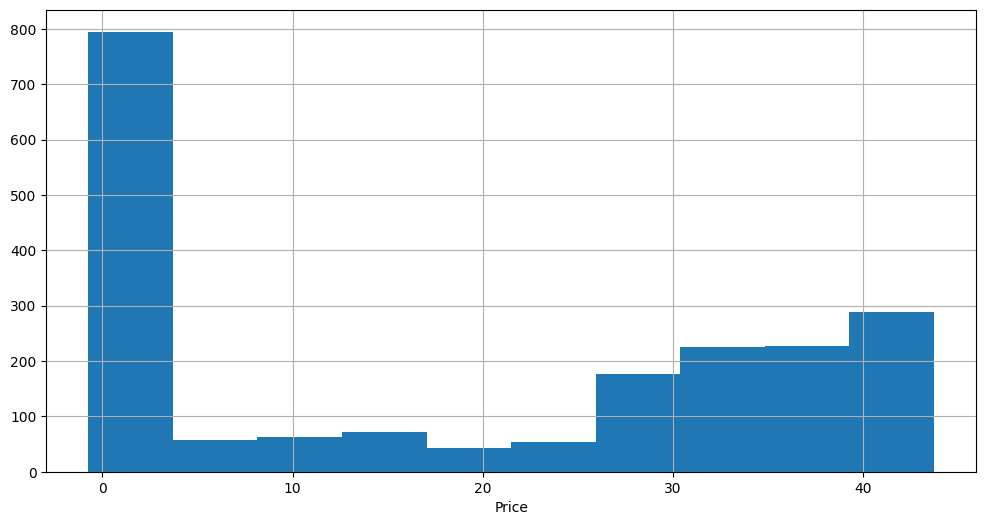

In [8]:
analyze_series(df_train.TargetPrice-df_train.BSAprox)
analyze_series(df_val.TargetPrice-df_val.BSAprox)

In [9]:
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_val) * np.sum((df_val.TargetPrice - df_val.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)

In [10]:
# import torch.multiprocessing as mp
train_df = CustomDataset(df_train)
val_df = CustomDataset(df_val)
from torch.optim.lr_scheduler import ReduceLROnPlateau
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    val_df,
    batch_size=32,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "SGD": torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.7),
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE),
    "Adam": torch.optim.Adam(model.parameters(), lr=LEARNING_RATE),
    "Adamax": torch.optim.Adamax(
        model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99)
    ),
}
criteriation = nn.MSELoss()

In [11]:
from torch.optim.lr_scheduler import CosineAnnealingLR


def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()  # Step the scheduler
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the CosineAnnealingLR scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCH, eta_min=0)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}"
        )

In [12]:
train_loss_dict = {}
val_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, val_loss_dict)

Optimizer: SGD


100%|██████████| 63/63 [00:00<00:00, 284.45it/s]

Epoch 1, train loss: 297.0599, val loss: 285.5799



100%|██████████| 63/63 [00:00<00:00, 229.79it/s]

Epoch 2, train loss: 289.0728, val loss: 284.4749



100%|██████████| 63/63 [00:00<00:00, 241.13it/s]

Epoch 3, train loss: 287.5002, val loss: 293.7863



100%|██████████| 63/63 [00:00<00:00, 240.07it/s]

Epoch 4, train loss: 286.8638, val loss: 294.9240



100%|██████████| 63/63 [00:00<00:00, 252.16it/s]

Epoch 5, train loss: 286.4199, val loss: 283.8882



100%|██████████| 63/63 [00:00<00:00, 229.21it/s]

Epoch 6, train loss: 286.4299, val loss: 284.7578



100%|██████████| 63/63 [00:00<00:00, 215.12it/s]

Epoch 7, train loss: 286.2247, val loss: 283.8388



100%|██████████| 63/63 [00:00<00:00, 215.95it/s]

Epoch 8, train loss: 285.7193, val loss: 285.5897



100%|██████████| 63/63 [00:00<00:00, 246.65it/s]

Epoch 9, train loss: 285.7680, val loss: 284.6190



100%|██████████| 63/63 [00:00<00:00, 224.66it/s]

Epoch 10, train loss: 285.3079, val loss: 283.8964



100%|██████████| 63/63 [00:00<00:00, 237.25it/s]

Epoch 11, train loss: 284.8116, val loss: 284.1866



100%|██████████| 63/63 [00:00<00:00, 230.77it/s]

Epoch 12, train loss: 285.0192, val loss: 284.4541



100%|██████████| 63/63 [00:00<00:00, 244.12it/s]

Epoch 13, train loss: 284.5441, val loss: 285.0268



100%|██████████| 63/63 [00:00<00:00, 235.04it/s]

Epoch 14, train loss: 284.5733, val loss: 285.2008



100%|██████████| 63/63 [00:00<00:00, 238.99it/s]

Epoch 15, train loss: 284.8869, val loss: 284.6809



100%|██████████| 63/63 [00:00<00:00, 231.49it/s]

Epoch 16, train loss: 284.3710, val loss: 285.8058



100%|██████████| 63/63 [00:00<00:00, 247.64it/s]

Epoch 17, train loss: 284.2695, val loss: 285.6766



100%|██████████| 63/63 [00:00<00:00, 222.26it/s]

Epoch 18, train loss: 284.6273, val loss: 284.1772



100%|██████████| 63/63 [00:00<00:00, 241.65it/s]

Epoch 19, train loss: 284.4332, val loss: 284.1668



100%|██████████| 63/63 [00:00<00:00, 248.93it/s]

Epoch 20, train loss: 284.3471, val loss: 284.3639
Optimizer: RMSprop



100%|██████████| 63/63 [00:00<00:00, 255.26it/s]

Epoch 1, train loss: 284.8592, val loss: 284.5761



100%|██████████| 63/63 [00:00<00:00, 246.38it/s]

Epoch 2, train loss: 284.4120, val loss: 283.7766



100%|██████████| 63/63 [00:00<00:00, 265.08it/s]

Epoch 3, train loss: 284.3886, val loss: 284.1483



100%|██████████| 63/63 [00:00<00:00, 276.50it/s]

Epoch 4, train loss: 283.9115, val loss: 284.4099



100%|██████████| 63/63 [00:00<00:00, 265.16it/s]

Epoch 5, train loss: 284.2900, val loss: 284.0759



100%|██████████| 63/63 [00:00<00:00, 273.47it/s]

Epoch 6, train loss: 283.9690, val loss: 284.4222



100%|██████████| 63/63 [00:00<00:00, 290.07it/s]

Epoch 7, train loss: 284.0172, val loss: 284.2026



100%|██████████| 63/63 [00:00<00:00, 284.09it/s]

Epoch 8, train loss: 284.2974, val loss: 284.1710



100%|██████████| 63/63 [00:00<00:00, 259.97it/s]

Epoch 9, train loss: 284.2441, val loss: 284.2920



100%|██████████| 63/63 [00:00<00:00, 255.58it/s]

Epoch 10, train loss: 283.8461, val loss: 284.2355



100%|██████████| 63/63 [00:00<00:00, 251.47it/s]

Epoch 11, train loss: 283.8162, val loss: 284.1418



100%|██████████| 63/63 [00:00<00:00, 232.28it/s]

Epoch 12, train loss: 283.6859, val loss: 284.4379



100%|██████████| 63/63 [00:00<00:00, 264.79it/s]

Epoch 13, train loss: 283.6005, val loss: 284.9367



100%|██████████| 63/63 [00:00<00:00, 257.40it/s]

Epoch 14, train loss: 283.5447, val loss: 284.2164



100%|██████████| 63/63 [00:00<00:00, 211.68it/s]


Epoch 15, train loss: 283.4699, val loss: 284.2281


100%|██████████| 63/63 [00:00<00:00, 236.66it/s]

Epoch 16, train loss: 283.2464, val loss: 284.2353



100%|██████████| 63/63 [00:00<00:00, 237.15it/s]

Epoch 17, train loss: 283.1633, val loss: 284.1578



100%|██████████| 63/63 [00:00<00:00, 235.79it/s]

Epoch 18, train loss: 283.1458, val loss: 284.2251



100%|██████████| 63/63 [00:00<00:00, 241.04it/s]

Epoch 19, train loss: 283.0682, val loss: 284.2219



100%|██████████| 63/63 [00:00<00:00, 216.74it/s]

Epoch 20, train loss: 283.0389, val loss: 284.2156
Optimizer: Adam



100%|██████████| 63/63 [00:00<00:00, 253.53it/s]

Epoch 1, train loss: 283.9108, val loss: 284.7843



100%|██████████| 63/63 [00:00<00:00, 228.45it/s]

Epoch 2, train loss: 283.7531, val loss: 284.7977



100%|██████████| 63/63 [00:00<00:00, 217.00it/s]

Epoch 3, train loss: 283.8350, val loss: 284.1333



100%|██████████| 63/63 [00:00<00:00, 240.00it/s]

Epoch 4, train loss: 283.8078, val loss: 284.5184



100%|██████████| 63/63 [00:00<00:00, 215.18it/s]

Epoch 5, train loss: 283.5418, val loss: 284.9075



100%|██████████| 63/63 [00:00<00:00, 216.95it/s]

Epoch 6, train loss: 283.3970, val loss: 283.9351



100%|██████████| 63/63 [00:00<00:00, 257.67it/s]

Epoch 7, train loss: 283.3933, val loss: 283.8917



100%|██████████| 63/63 [00:00<00:00, 218.53it/s]

Epoch 8, train loss: 283.2786, val loss: 284.1576



100%|██████████| 63/63 [00:00<00:00, 180.61it/s]

Epoch 9, train loss: 283.3155, val loss: 284.4946



100%|██████████| 63/63 [00:00<00:00, 249.93it/s]

Epoch 10, train loss: 283.2641, val loss: 284.4789



100%|██████████| 63/63 [00:00<00:00, 241.78it/s]

Epoch 11, train loss: 282.9363, val loss: 284.6198



100%|██████████| 63/63 [00:00<00:00, 224.85it/s]

Epoch 12, train loss: 283.1041, val loss: 284.8921



100%|██████████| 63/63 [00:00<00:00, 216.87it/s]

Epoch 13, train loss: 282.8754, val loss: 284.5086



100%|██████████| 63/63 [00:00<00:00, 231.31it/s]

Epoch 14, train loss: 282.5529, val loss: 284.2835



100%|██████████| 63/63 [00:00<00:00, 218.99it/s]

Epoch 15, train loss: 282.4292, val loss: 284.2905



100%|██████████| 63/63 [00:00<00:00, 247.83it/s]

Epoch 16, train loss: 282.6282, val loss: 284.4663



100%|██████████| 63/63 [00:00<00:00, 240.86it/s]

Epoch 17, train loss: 282.2280, val loss: 284.4680



100%|██████████| 63/63 [00:00<00:00, 262.32it/s]

Epoch 18, train loss: 282.1751, val loss: 284.4486



100%|██████████| 63/63 [00:00<00:00, 237.55it/s]

Epoch 19, train loss: 282.1118, val loss: 284.4369



100%|██████████| 63/63 [00:00<00:00, 240.23it/s]

Epoch 20, train loss: 282.0776, val loss: 284.4362
Optimizer: Adamax



100%|██████████| 63/63 [00:00<00:00, 268.87it/s]

Epoch 1, train loss: 282.7541, val loss: 284.2119



100%|██████████| 63/63 [00:00<00:00, 215.81it/s]

Epoch 2, train loss: 282.4978, val loss: 284.2052



100%|██████████| 63/63 [00:00<00:00, 226.60it/s]

Epoch 3, train loss: 282.4317, val loss: 284.2959



100%|██████████| 63/63 [00:00<00:00, 236.07it/s]

Epoch 4, train loss: 282.4135, val loss: 284.3588



100%|██████████| 63/63 [00:00<00:00, 234.79it/s]

Epoch 5, train loss: 282.0719, val loss: 284.2706



100%|██████████| 63/63 [00:00<00:00, 220.73it/s]

Epoch 6, train loss: 282.1146, val loss: 284.7876



100%|██████████| 63/63 [00:00<00:00, 230.70it/s]

Epoch 7, train loss: 281.9950, val loss: 284.7211



100%|██████████| 63/63 [00:00<00:00, 221.48it/s]

Epoch 8, train loss: 281.7910, val loss: 284.5819



100%|██████████| 63/63 [00:00<00:00, 235.98it/s]

Epoch 9, train loss: 281.8120, val loss: 284.7301



100%|██████████| 63/63 [00:00<00:00, 237.53it/s]

Epoch 10, train loss: 281.6889, val loss: 284.8100



100%|██████████| 63/63 [00:00<00:00, 223.56it/s]

Epoch 11, train loss: 281.5885, val loss: 284.6772



100%|██████████| 63/63 [00:00<00:00, 232.65it/s]

Epoch 12, train loss: 281.5013, val loss: 284.5926



100%|██████████| 63/63 [00:00<00:00, 221.14it/s]

Epoch 13, train loss: 281.3850, val loss: 284.7503



100%|██████████| 63/63 [00:00<00:00, 238.68it/s]

Epoch 14, train loss: 281.3271, val loss: 284.8291



100%|██████████| 63/63 [00:00<00:00, 216.54it/s]

Epoch 15, train loss: 281.1975, val loss: 284.6622



100%|██████████| 63/63 [00:00<00:00, 268.46it/s]

Epoch 16, train loss: 281.1853, val loss: 284.7624



100%|██████████| 63/63 [00:00<00:00, 244.04it/s]

Epoch 17, train loss: 281.1050, val loss: 284.8165



100%|██████████| 63/63 [00:00<00:00, 223.49it/s]

Epoch 18, train loss: 281.0732, val loss: 284.7922



100%|██████████| 63/63 [00:00<00:00, 237.67it/s]

Epoch 19, train loss: 281.0374, val loss: 284.7773



100%|██████████| 63/63 [00:00<00:00, 246.69it/s]

Epoch 20, train loss: 281.0183, val loss: 284.7782


In [15]:
import matplotlib.pyplot as plt


def plot_dictionaries(dict1, dict2, initial_train, initial_val, save_path=None):
    # Set global font size
    plt.rcParams.update(
        {"font.size": 22}
    )  # Twice as big as the default font size (default is usually 10 or 12)

    fig, axes = plt.subplots(1, 2, figsize=(22, 8))  # Create a figure with two subplots

    # Plot for dictionary 1
    for key, values in dict1.items():
        axes[0].plot(
            range(5, len(values) + 1), values[4:], label=key, marker="*"
        )  # Start from second element
        axes[0].set_xlabel("Epochs")
        axes[0].set_ylabel("MSE Loss")
        axes[0].set_title(f"Train losses, initial: {initial_train.round(2)}")
        axes[0].grid(True)

    # Plot for dictionary 2
    for key, values in dict2.items():
        axes[1].plot(range(5, len(values) + 1), values[4:], label=key, marker="*")
        axes[1].set_xlabel("Epochs")
        axes[1].set_ylabel("MSE Loss")
        axes[1].set_title(f"Validation losses, initial: {initial_val.round(2)}")
        axes[1].grid(True)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    plt.show()

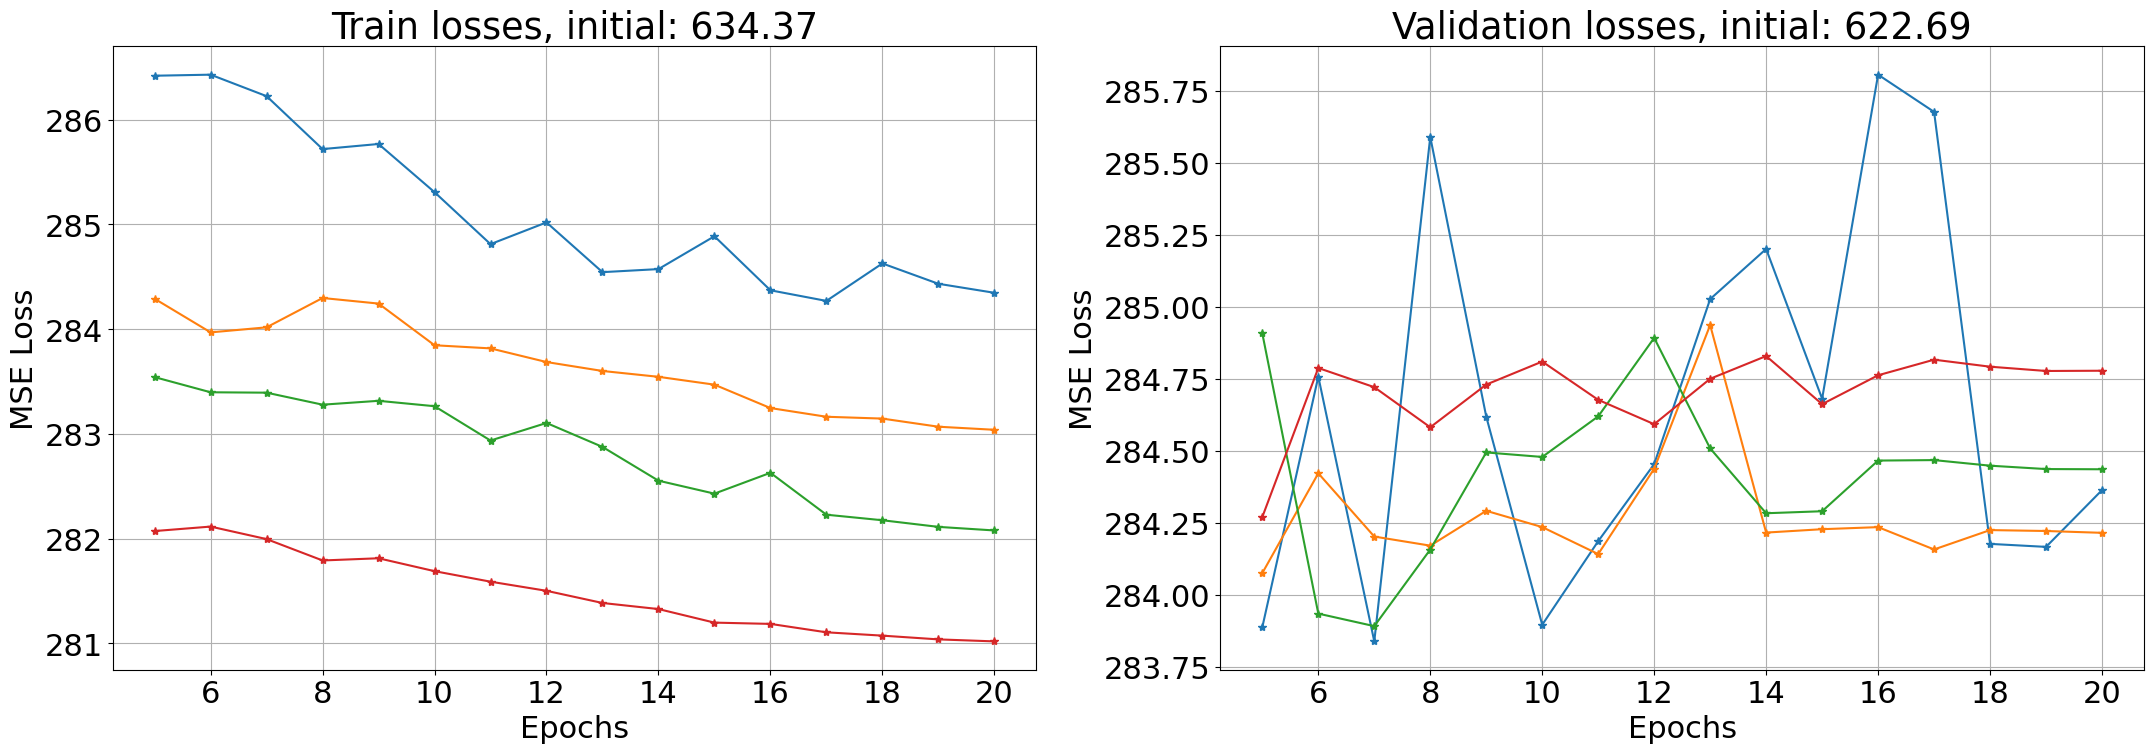

In [16]:
# Plot
plot_dictionaries(
    train_loss_dict,
    val_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_test.png",
)

### So for full training we will take Adam

In [75]:
# hyperparams for training
# df_real = pd.read_csv("../train_data/put_df_with_approx.csv", index_col=0)
N_EPOCH = 100
RISK_FREE = 0.03
SIGMA = 0.4
LEARNING_RATE = 0.00008
HIDDEN_LAYER = 28
HIDDEN_WIDTH = 128
# EXPERIMENT_NAME = "exp_put_5_final"
# MODEL_TYPE = AmericanPut_gated3
# experiment_dir = f"../experiments_dir/{EXPERIMENT_NAME}"
# os.makedirs(experiment_dir, exist_ok=True)

In [76]:
import logging
from datetime import datetime

logger = logging.getLogger()
current_date = datetime.now().strftime("%Y-%m-%d")
log_file_name = f"{experiment_dir}/{EXPERIMENT_NAME}_log_{current_date}.log"
fhandler = logging.FileHandler(filename=log_file_name, mode="w")
formatter = logging.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)
logger.setLevel(logging.INFO)

In [77]:
logging.info(f"N_EPOCH: {N_EPOCH}")
logging.info(f"LEARNING_RATE: {LEARNING_RATE}")
logging.info(f"HIDDEN_LAYER: {HIDDEN_LAYER}")
logging.info(f"HIDDEN_WIDTH: {HIDDEN_WIDTH}")
# logging.info(f"N_sample: {N_sample}")
logging.info(f"EXPERIMENT_NAME: {EXPERIMENT_NAME}")
logging.info(f"Model type: {MODEL_TYPE.__name__}")

In [78]:
df_train, df_test = train_test_split(df, test_size=0.2)
logging.info(f"train set size: {df_train.shape}")
logging.info(f"test set size: {df_test.shape}")
initial_mse_train = (
    1 / len(df_train) * np.sum((df_train.TargetPrice - df_train.BSAprox) ** 2)
)
initial_mse_val = 1 / len(df_test) * np.sum((df_test.TargetPrice - df_test.BSAprox) ** 2)
logging.info(
    f"Initial MSE train: {initial_mse_train.round(4)}, Initial MSE val: {initial_mse_val.round(4)}"
)
train_df = CustomDataset(df_train)
test_df = CustomDataset(df_test)

In [79]:
from torch.optim.lr_scheduler import CosineAnnealingLR


def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()  # Step the scheduler
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the CosineAnnealingLR scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCH, eta_min=0)

    for i in range(N_EPOCH):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, val loss: {val_loss:.4f}"
        )

In [80]:
# import torch.multiprocessing as mp
# from torch.optim.lr_scheduler import ReduceLROnPlateau

# # Set the multiprocessing start method to 'spawn'
# mp.set_start_method("spawn", force=True)
model = MODEL_TYPE(5, 1, HIDDEN_WIDTH, HIDDEN_LAYER).to(DEVICE)
logging.info(
    f"Total number of learnable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}"
)
train_dataloader = DataLoader(
    train_df,
    batch_size=32,
    shuffle=True,
    num_workers=8,
    # generator=torch.Generator(device=DEVICE),
)
val_dataloader = DataLoader(
    test_df,
    batch_size=32,
    shuffle=False,
    num_workers=8,
)
optimizers_list = {
    "RMSprop": torch.optim.RMSprop(model.parameters(), lr=LEARNING_RATE),
}
criteriation = nn.MSELoss()

In [81]:
train_loss_dict = {}
test_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, test_loss_dict, final=True)

Optimizer: RMSprop


100%|██████████| 63/63 [00:00<00:00, 263.80it/s]

Epoch 1, train loss: 295.0234, val loss: 286.1548



100%|██████████| 63/63 [00:00<00:00, 295.35it/s]

Epoch 2, train loss: 286.9034, val loss: 285.4312



100%|██████████| 63/63 [00:00<00:00, 316.33it/s]

Epoch 3, train loss: 286.3307, val loss: 283.4039



100%|██████████| 63/63 [00:00<00:00, 249.43it/s]

Epoch 4, train loss: 286.2578, val loss: 284.5220



100%|██████████| 63/63 [00:00<00:00, 287.18it/s]

Epoch 5, train loss: 285.3968, val loss: 282.3689



100%|██████████| 63/63 [00:00<00:00, 275.72it/s]

Epoch 6, train loss: 285.5365, val loss: 283.0901



100%|██████████| 63/63 [00:00<00:00, 305.81it/s]

Epoch 7, train loss: 285.2634, val loss: 283.3694



100%|██████████| 63/63 [00:00<00:00, 303.83it/s]

Epoch 8, train loss: 285.0723, val loss: 284.0288



100%|██████████| 63/63 [00:00<00:00, 289.67it/s]

Epoch 9, train loss: 284.9907, val loss: 283.1813



100%|██████████| 63/63 [00:00<00:00, 310.70it/s]

Epoch 10, train loss: 285.0622, val loss: 282.8920



100%|██████████| 63/63 [00:00<00:00, 296.70it/s]

Epoch 11, train loss: 284.9846, val loss: 285.1742



100%|██████████| 63/63 [00:00<00:00, 305.89it/s]

Epoch 12, train loss: 285.4581, val loss: 282.8478



100%|██████████| 63/63 [00:00<00:00, 299.21it/s]

Epoch 13, train loss: 285.9731, val loss: 283.3841



100%|██████████| 63/63 [00:00<00:00, 293.18it/s]

Epoch 14, train loss: 286.4309, val loss: 285.3064



100%|██████████| 63/63 [00:00<00:00, 292.13it/s]

Epoch 15, train loss: 286.0215, val loss: 283.4021



100%|██████████| 63/63 [00:00<00:00, 287.66it/s]

Epoch 16, train loss: 285.1101, val loss: 283.3032



100%|██████████| 63/63 [00:00<00:00, 289.71it/s]

Epoch 17, train loss: 285.1494, val loss: 283.1804



100%|██████████| 63/63 [00:00<00:00, 304.82it/s]

Epoch 18, train loss: 285.3129, val loss: 283.0604



100%|██████████| 63/63 [00:00<00:00, 303.09it/s]

Epoch 19, train loss: 285.2124, val loss: 283.3641



100%|██████████| 63/63 [00:00<00:00, 290.37it/s]

Epoch 20, train loss: 285.2743, val loss: 283.9095



100%|██████████| 63/63 [00:00<00:00, 286.53it/s]

Epoch 21, train loss: 285.2352, val loss: 282.5707



100%|██████████| 63/63 [00:00<00:00, 309.70it/s]

Epoch 22, train loss: 284.5178, val loss: 286.5695



100%|██████████| 63/63 [00:00<00:00, 290.13it/s]

Epoch 23, train loss: 284.9596, val loss: 282.6236



100%|██████████| 63/63 [00:00<00:00, 285.82it/s]

Epoch 24, train loss: 284.9276, val loss: 283.8942



100%|██████████| 63/63 [00:00<00:00, 285.51it/s]

Epoch 25, train loss: 285.0425, val loss: 282.5960



100%|██████████| 63/63 [00:00<00:00, 296.45it/s]

Epoch 26, train loss: 285.0649, val loss: 282.8872



100%|██████████| 63/63 [00:00<00:00, 286.60it/s]

Epoch 27, train loss: 284.7700, val loss: 283.5741



100%|██████████| 63/63 [00:00<00:00, 280.42it/s]

Epoch 28, train loss: 284.9903, val loss: 283.0992



100%|██████████| 63/63 [00:00<00:00, 268.65it/s]

Epoch 29, train loss: 285.0197, val loss: 282.6000



100%|██████████| 63/63 [00:00<00:00, 186.52it/s]

Epoch 30, train loss: 284.3409, val loss: 282.5538



100%|██████████| 63/63 [00:00<00:00, 248.67it/s]

Epoch 31, train loss: 284.8075, val loss: 282.6572



100%|██████████| 63/63 [00:00<00:00, 284.79it/s]

Epoch 32, train loss: 284.3480, val loss: 284.2262



100%|██████████| 63/63 [00:00<00:00, 270.55it/s]

Epoch 33, train loss: 284.3186, val loss: 283.4200



100%|██████████| 63/63 [00:00<00:00, 276.45it/s]

Epoch 34, train loss: 284.8992, val loss: 283.2912



100%|██████████| 63/63 [00:00<00:00, 275.57it/s]

Epoch 35, train loss: 284.6348, val loss: 283.3488



100%|██████████| 63/63 [00:00<00:00, 274.14it/s]

Epoch 36, train loss: 284.2371, val loss: 283.2226



100%|██████████| 63/63 [00:00<00:00, 266.96it/s]

Epoch 37, train loss: 284.0766, val loss: 283.1110



100%|██████████| 63/63 [00:00<00:00, 281.29it/s]

Epoch 38, train loss: 284.2991, val loss: 284.1061



100%|██████████| 63/63 [00:00<00:00, 271.17it/s]

Epoch 39, train loss: 284.2364, val loss: 283.7720



  0%|          | 0/63 [00:00<?, ?it/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7c13067405e0>
Traceback (most recent call last):
  File "/home/strongich/miniconda3/envs/main/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/home/strongich/miniconda3/envs/main/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
                                   ^^^^^^^^^^^^^^^^^^^^
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
100%|██████████| 63/63 [00:00<00:00, 147.80it/s]

Epoch 40, train loss: 284.2254, val loss: 283.1755



100%|██████████| 63/63 [00:00<00:00, 288.65it/s]

Epoch 41, train loss: 283.8492, val loss: 283.4712



100%|██████████| 63/63 [00:00<00:00, 286.58it/s]

Epoch 42, train loss: 284.0043, val loss: 283.4213



100%|██████████| 63/63 [00:00<00:00, 287.28it/s]

Epoch 43, train loss: 284.2996, val loss: 282.6490



100%|██████████| 63/63 [00:00<00:00, 275.21it/s]

Epoch 44, train loss: 283.8289, val loss: 282.8434



100%|██████████| 63/63 [00:00<00:00, 291.52it/s]

Epoch 45, train loss: 283.7712, val loss: 282.9538



100%|██████████| 63/63 [00:00<00:00, 258.95it/s]

Epoch 46, train loss: 284.0215, val loss: 282.5079



100%|██████████| 63/63 [00:00<00:00, 296.90it/s]

Epoch 47, train loss: 284.0071, val loss: 283.1211



100%|██████████| 63/63 [00:00<00:00, 290.50it/s]

Epoch 48, train loss: 283.7275, val loss: 282.5766



100%|██████████| 63/63 [00:00<00:00, 285.87it/s]

Epoch 49, train loss: 283.8931, val loss: 282.8772



100%|██████████| 63/63 [00:00<00:00, 291.60it/s]

Epoch 50, train loss: 283.9789, val loss: 283.2922



100%|██████████| 63/63 [00:00<00:00, 283.83it/s]

Epoch 51, train loss: 283.7663, val loss: 283.4704



100%|██████████| 63/63 [00:00<00:00, 282.69it/s]

Epoch 52, train loss: 283.7678, val loss: 283.2109



100%|██████████| 63/63 [00:00<00:00, 291.82it/s]

Epoch 53, train loss: 283.6305, val loss: 283.0791



100%|██████████| 63/63 [00:00<00:00, 280.80it/s]

Epoch 54, train loss: 283.3969, val loss: 283.4383



100%|██████████| 63/63 [00:00<00:00, 296.58it/s]

Epoch 55, train loss: 283.2058, val loss: 283.2879



100%|██████████| 63/63 [00:00<00:00, 287.25it/s]

Epoch 56, train loss: 283.0692, val loss: 283.9851



100%|██████████| 63/63 [00:00<00:00, 296.82it/s]

Epoch 57, train loss: 283.1664, val loss: 283.3952



100%|██████████| 63/63 [00:00<00:00, 283.17it/s]

Epoch 58, train loss: 283.0235, val loss: 284.0812



100%|██████████| 63/63 [00:00<00:00, 283.76it/s]

Epoch 59, train loss: 283.2518, val loss: 284.3568



100%|██████████| 63/63 [00:00<00:00, 284.84it/s]

Epoch 60, train loss: 282.9344, val loss: 284.0051



100%|██████████| 63/63 [00:00<00:00, 293.75it/s]

Epoch 61, train loss: 282.7564, val loss: 284.3685



100%|██████████| 63/63 [00:00<00:00, 297.00it/s]

Epoch 62, train loss: 282.4829, val loss: 284.8989



100%|██████████| 63/63 [00:00<00:00, 284.02it/s]

Epoch 63, train loss: 282.7067, val loss: 285.2570



100%|██████████| 63/63 [00:00<00:00, 246.77it/s]

Epoch 64, train loss: 282.8125, val loss: 284.3641



100%|██████████| 63/63 [00:00<00:00, 286.38it/s]

Epoch 65, train loss: 282.6209, val loss: 283.8479



100%|██████████| 63/63 [00:00<00:00, 278.77it/s]

Epoch 66, train loss: 282.6895, val loss: 284.1376



100%|██████████| 63/63 [00:00<00:00, 282.03it/s]

Epoch 67, train loss: 282.6264, val loss: 283.8331



100%|██████████| 63/63 [00:00<00:00, 268.51it/s]

Epoch 68, train loss: 282.4196, val loss: 284.2169



100%|██████████| 63/63 [00:00<00:00, 298.33it/s]

Epoch 69, train loss: 282.4722, val loss: 284.9735



100%|██████████| 63/63 [00:00<00:00, 289.23it/s]

Epoch 70, train loss: 282.6975, val loss: 284.5907



100%|██████████| 63/63 [00:00<00:00, 299.31it/s]

Epoch 71, train loss: 282.7542, val loss: 284.0302



100%|██████████| 63/63 [00:00<00:00, 284.34it/s]

Epoch 72, train loss: 282.5280, val loss: 284.0099



100%|██████████| 63/63 [00:00<00:00, 287.57it/s]

Epoch 73, train loss: 282.5538, val loss: 284.5768



100%|██████████| 63/63 [00:00<00:00, 290.21it/s]

Epoch 74, train loss: 282.3821, val loss: 284.5437



100%|██████████| 63/63 [00:00<00:00, 286.82it/s]

Epoch 75, train loss: 282.3902, val loss: 284.4568



100%|██████████| 63/63 [00:00<00:00, 295.53it/s]

Epoch 76, train loss: 282.3199, val loss: 283.8653



100%|██████████| 63/63 [00:00<00:00, 270.85it/s]

Epoch 77, train loss: 282.3909, val loss: 283.9742



100%|██████████| 63/63 [00:00<00:00, 279.03it/s]

Epoch 78, train loss: 282.2992, val loss: 284.5614



100%|██████████| 63/63 [00:00<00:00, 301.40it/s]

Epoch 79, train loss: 282.0387, val loss: 284.5393



100%|██████████| 63/63 [00:00<00:00, 307.82it/s]

Epoch 80, train loss: 281.8872, val loss: 284.4195



100%|██████████| 63/63 [00:00<00:00, 287.23it/s]

Epoch 81, train loss: 281.9337, val loss: 284.4718



100%|██████████| 63/63 [00:00<00:00, 289.25it/s]

Epoch 82, train loss: 281.8552, val loss: 284.8538



100%|██████████| 63/63 [00:00<00:00, 304.99it/s]

Epoch 83, train loss: 281.6989, val loss: 284.4877



100%|██████████| 63/63 [00:00<00:00, 268.58it/s]

Epoch 84, train loss: 281.6455, val loss: 284.5904



100%|██████████| 63/63 [00:00<00:00, 287.20it/s]

Epoch 85, train loss: 281.6617, val loss: 284.8457



100%|██████████| 63/63 [00:00<00:00, 280.50it/s]

Epoch 86, train loss: 281.7163, val loss: 284.9405



100%|██████████| 63/63 [00:00<00:00, 259.29it/s]

Epoch 87, train loss: 281.7828, val loss: 284.8034



100%|██████████| 63/63 [00:00<00:00, 300.43it/s]

Epoch 88, train loss: 281.6596, val loss: 284.8106



100%|██████████| 63/63 [00:00<00:00, 291.77it/s]

Epoch 89, train loss: 281.6973, val loss: 284.7933



100%|██████████| 63/63 [00:00<00:00, 292.79it/s]

Epoch 90, train loss: 281.6457, val loss: 284.6413



100%|██████████| 63/63 [00:00<00:00, 297.71it/s]

Epoch 91, train loss: 281.5122, val loss: 284.7699



100%|██████████| 63/63 [00:00<00:00, 282.95it/s]

Epoch 92, train loss: 281.4749, val loss: 284.8893



100%|██████████| 63/63 [00:00<00:00, 283.52it/s]

Epoch 93, train loss: 281.5003, val loss: 285.2821



100%|██████████| 63/63 [00:00<00:00, 284.72it/s]

Epoch 94, train loss: 281.4752, val loss: 285.0169



100%|██████████| 63/63 [00:00<00:00, 294.58it/s]

Epoch 95, train loss: 281.4691, val loss: 284.8693



100%|██████████| 63/63 [00:00<00:00, 295.24it/s]

Epoch 96, train loss: 281.2943, val loss: 284.9616



100%|██████████| 63/63 [00:00<00:00, 294.19it/s]

Epoch 97, train loss: 281.2679, val loss: 284.7369



100%|██████████| 63/63 [00:00<00:00, 292.96it/s]

Epoch 98, train loss: 281.2656, val loss: 284.8835



100%|██████████| 63/63 [00:00<00:00, 304.42it/s]

Epoch 99, train loss: 281.2697, val loss: 284.8655



100%|██████████| 63/63 [00:00<00:00, 283.84it/s]

Epoch 100, train loss: 281.2145, val loss: 284.8712


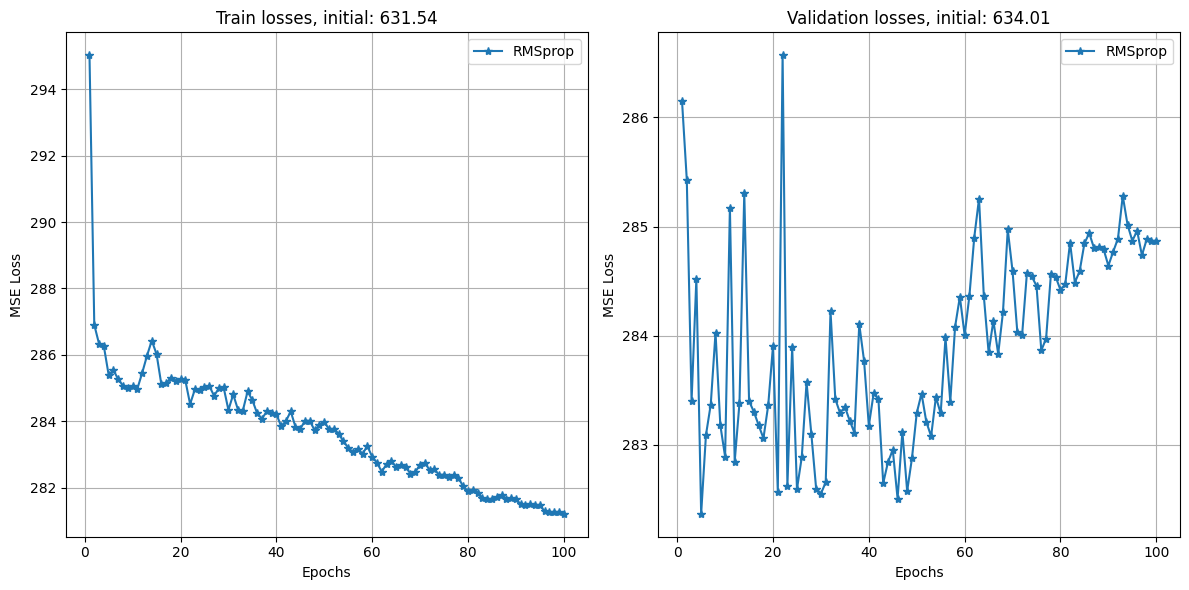

In [82]:
plot_dictionaries(
    train_loss_dict,
    test_loss_dict,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final_2.png",
)

In [73]:
import json

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "w") as json_file:
    json.dump(train_loss_dict, json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "w") as json_file:
    json.dump(test_loss_dict, json_file)

In [74]:
logging.info(
    f"% of variation before training: {(initial_mse_train/(df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(train_loss_dict['RMSprop'][41]/ (df_train.TargetPrice - df_train.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation before training: {(initial_mse_val/(df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)
logging.info(
    f"% of variation after training: {(test_loss_dict['RMSprop'][41] / (df_test.TargetPrice - df_test.BSAprox).var() * 100).round(2)}"
)

In [29]:
def train_model(model, train_dataloader, optimizer, scheduler, criteriation, device):
    model.train()
    train_losses = []
    for batch_idx, data in tqdm(
        enumerate(train_dataloader), total=len(train_dataloader)
    ):
        optimizer.zero_grad()
        inputs = data["input"].to(device)
        outputs = data["output"].to(device).view(-1, 1)
        pred = model(inputs).view(-1, 1)
        loss = criteriation(outputs, pred)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step(np.mean(train_losses))  # Step the scheduler based on training loss
    return np.mean(train_losses)


def validate_model(model, val_dataloader, criteriation, device):
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch_idx, data in tqdm(
            enumerate(val_dataloader), total=len(val_dataloader)
        ):
            inputs = data["input"].to(device)
            outputs = data["output"].to(device).view(-1, 1)
            pred = model(inputs).view(-1, 1)
            loss = criteriation(outputs, pred)
            val_losses.append(loss.item())
    return np.mean(val_losses)


def train_cycle(optimizer_name, optimizer, train_loss_dict, val_loss_dict, final=False):
    print(f"Optimizer: {optimizer_name}")
    train_loss_dict[optimizer_name] = []
    val_loss_dict[optimizer_name] = []
    logging.info(f"Optimizer: {optimizer_name}")

    # Define the ReduceLROnPlateau scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode="min", patience=5, verbose=True)

    for i in range(N_EPOCH, 100):
        train_loss = train_model(
            model, train_dataloader, optimizer, scheduler, criteriation, DEVICE
        )
        train_loss_dict[optimizer_name].append(train_loss)
        val_loss = validate_model(model, val_dataloader, criteriation, DEVICE)
        val_loss_dict[optimizer_name].append(val_loss)
        if final:
            torch.save(
                model.state_dict(), f"{experiment_dir}/{EXPERIMENT_NAME}_{i}.pth"
            )
        print(f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}")
        logging.info(
            f"Epoch {i+1}, train loss: {train_loss:.4f}, test loss: {val_loss:.4f}"
        )

In [30]:
train_loss_dict = {}
test_loss_dict = {}
for name, optimizer in optimizers_list.items():
    train_cycle(name, optimizer, train_loss_dict, test_loss_dict, final=True)

Optimizer: Adam


100%|██████████| 698/698 [00:02<00:00, 346.55it/s]

Epoch 51, train loss: 15.1520, test loss: 15.0572



100%|██████████| 698/698 [00:02<00:00, 321.40it/s]

Epoch 52, train loss: 15.3887, test loss: 14.7960



100%|██████████| 698/698 [00:01<00:00, 350.77it/s]

Epoch 53, train loss: 15.1600, test loss: 15.0739



100%|██████████| 698/698 [00:01<00:00, 362.00it/s]

Epoch 54, train loss: 15.5402, test loss: 14.8740



100%|██████████| 698/698 [00:01<00:00, 357.46it/s]

Epoch 55, train loss: 15.3245, test loss: 14.9195



100%|██████████| 698/698 [00:01<00:00, 368.30it/s]

Epoch 56, train loss: 14.5784, test loss: 15.5519



100%|██████████| 698/698 [00:01<00:00, 362.18it/s]

Epoch 57, train loss: 14.6905, test loss: 15.2107



100%|██████████| 698/698 [00:01<00:00, 363.73it/s]

Epoch 58, train loss: 14.7698, test loss: 15.0287



100%|██████████| 698/698 [00:01<00:00, 366.32it/s]

Epoch 59, train loss: 14.6966, test loss: 14.9380



100%|██████████| 698/698 [00:01<00:00, 360.32it/s]

Epoch 60, train loss: 14.7310, test loss: 14.8965



100%|██████████| 698/698 [00:01<00:00, 367.51it/s]

Epoch 61, train loss: 15.1140, test loss: 14.9883



100%|██████████| 2791/2791 [00:20<00:00, 133.78it/s]

Epoch 00012: reducing learning rate of group 0 to 3.0000e-06.



100%|██████████| 698/698 [00:02<00:00, 348.21it/s]

Epoch 62, train loss: 15.0032, test loss: 15.0009



100%|██████████| 698/698 [00:02<00:00, 333.69it/s]


Epoch 63, train loss: 13.9765, test loss: 14.9068


100%|██████████| 698/698 [00:01<00:00, 383.90it/s]

Epoch 64, train loss: 13.9467, test loss: 14.8981



100%|██████████| 698/698 [00:01<00:00, 386.41it/s]

Epoch 65, train loss: 13.9420, test loss: 14.8892



100%|██████████| 698/698 [00:01<00:00, 385.55it/s]

Epoch 66, train loss: 13.9126, test loss: 14.8817



100%|██████████| 698/698 [00:01<00:00, 383.74it/s]

Epoch 67, train loss: 13.9087, test loss: 14.8849



100%|██████████| 698/698 [00:01<00:00, 386.19it/s]

Epoch 68, train loss: 13.8657, test loss: 14.8844



100%|██████████| 698/698 [00:01<00:00, 381.88it/s]

Epoch 69, train loss: 13.8717, test loss: 14.8792



100%|██████████| 698/698 [00:01<00:00, 382.20it/s]

Epoch 70, train loss: 13.8497, test loss: 14.8795



100%|██████████| 698/698 [00:01<00:00, 376.96it/s]


Epoch 71, train loss: 13.8242, test loss: 14.8854


100%|██████████| 698/698 [00:01<00:00, 352.94it/s]

Epoch 72, train loss: 13.8136, test loss: 14.9072



100%|██████████| 698/698 [00:02<00:00, 341.90it/s]

Epoch 73, train loss: 13.8525, test loss: 14.8810



100%|██████████| 698/698 [00:02<00:00, 342.65it/s]

Epoch 74, train loss: 13.7920, test loss: 14.8710



100%|██████████| 698/698 [00:01<00:00, 356.31it/s]

Epoch 75, train loss: 13.8038, test loss: 14.8800



100%|██████████| 698/698 [00:01<00:00, 395.53it/s]

Epoch 76, train loss: 13.7929, test loss: 14.8801



100%|██████████| 698/698 [00:01<00:00, 409.48it/s]

Epoch 77, train loss: 13.7795, test loss: 14.8827



100%|██████████| 698/698 [00:01<00:00, 355.67it/s]

Epoch 78, train loss: 13.7519, test loss: 14.9581



100%|██████████| 698/698 [00:01<00:00, 358.27it/s]

Epoch 79, train loss: 13.7587, test loss: 14.8782



100%|██████████| 698/698 [00:02<00:00, 341.55it/s]

Epoch 80, train loss: 13.7785, test loss: 14.9013



100%|██████████| 698/698 [00:01<00:00, 353.28it/s]

Epoch 81, train loss: 13.7422, test loss: 14.8886



100%|██████████| 698/698 [00:01<00:00, 397.55it/s]

Epoch 82, train loss: 13.7631, test loss: 14.8928



100%|██████████| 698/698 [00:02<00:00, 336.77it/s]

Epoch 83, train loss: 13.7549, test loss: 14.8892



100%|██████████| 698/698 [00:01<00:00, 367.69it/s]

Epoch 84, train loss: 13.7512, test loss: 14.8932



100%|██████████| 698/698 [00:01<00:00, 352.76it/s]

Epoch 85, train loss: 13.7179, test loss: 14.8955



100%|██████████| 698/698 [00:01<00:00, 364.66it/s]

Epoch 86, train loss: 13.7321, test loss: 14.9013



100%|██████████| 698/698 [00:01<00:00, 359.67it/s]


Epoch 87, train loss: 13.7366, test loss: 14.8958


100%|██████████| 698/698 [00:01<00:00, 363.28it/s]

Epoch 88, train loss: 13.6819, test loss: 14.9143



100%|██████████| 698/698 [00:01<00:00, 379.32it/s]

Epoch 89, train loss: 13.6712, test loss: 14.9184



100%|██████████| 698/698 [00:01<00:00, 400.47it/s]

Epoch 90, train loss: 13.7265, test loss: 14.9111



100%|██████████| 698/698 [00:01<00:00, 424.63it/s]

Epoch 91, train loss: 13.6992, test loss: 14.9058



100%|██████████| 698/698 [00:01<00:00, 376.12it/s]

Epoch 92, train loss: 13.7273, test loss: 14.9105



100%|██████████| 698/698 [00:01<00:00, 371.47it/s]

Epoch 93, train loss: 13.6984, test loss: 14.9097



100%|██████████| 698/698 [00:01<00:00, 377.15it/s]


Epoch 94, train loss: 13.6989, test loss: 14.9163


100%|██████████| 2791/2791 [00:20<00:00, 137.37it/s]

Epoch 00045: reducing learning rate of group 0 to 3.0000e-07.



100%|██████████| 698/698 [00:01<00:00, 349.47it/s]

Epoch 95, train loss: 13.7266, test loss: 14.9154



100%|██████████| 698/698 [00:01<00:00, 353.70it/s]

Epoch 96, train loss: 13.5943, test loss: 14.9160



100%|██████████| 698/698 [00:01<00:00, 388.76it/s]

Epoch 97, train loss: 13.5934, test loss: 14.9140



100%|██████████| 698/698 [00:01<00:00, 378.01it/s]

Epoch 98, train loss: 13.5931, test loss: 14.9152



100%|██████████| 698/698 [00:01<00:00, 369.65it/s]

Epoch 99, train loss: 13.5932, test loss: 14.9155



100%|██████████| 698/698 [00:01<00:00, 377.52it/s]

Epoch 100, train loss: 13.5906, test loss: 14.9126


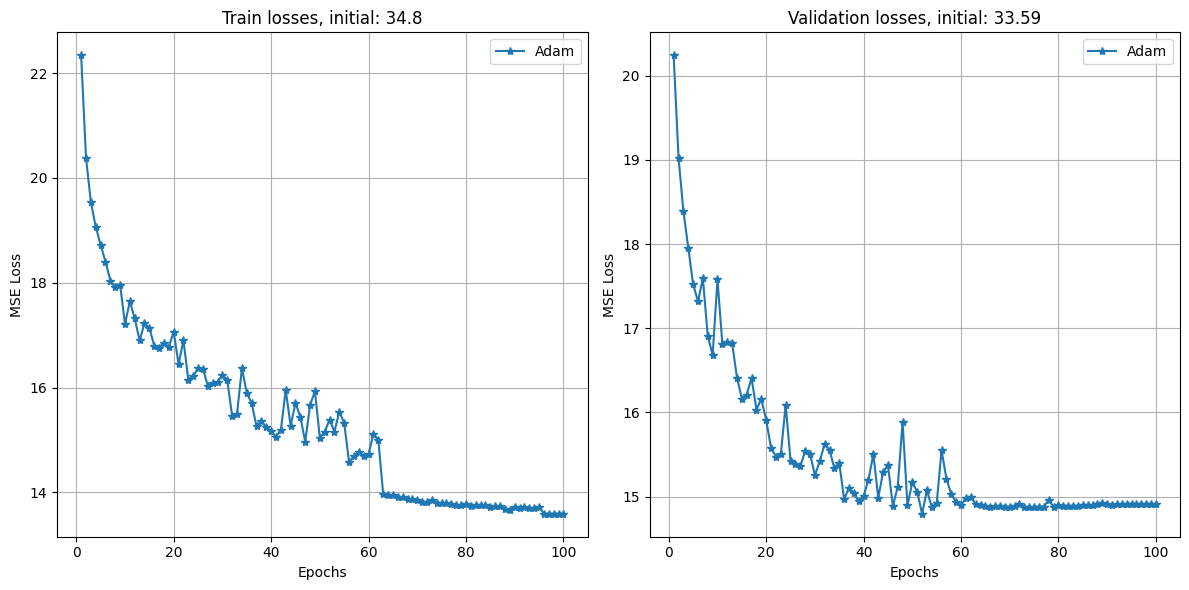

In [45]:
file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_train.json"
with open(file_path, "r") as json_file:
    first_50_train = json.load(json_file)

file_path = f"{experiment_dir}/{EXPERIMENT_NAME}_test.json"
with open(file_path, "r") as json_file:
    first_50_test = json.load(json_file)

train = np.concatenate((first_50_train["Adam"], train_loss_dict["Adam"]))
test = np.concatenate((first_50_test["Adam"], test_loss_dict["Adam"]))
train_all = {"Adam":train}
test_all = {"Adam":test}
plot_dictionaries(
    train_all,
    test_all,
    initial_mse_train,
    initial_mse_val,
    f"{experiment_dir}/{EXPERIMENT_NAME}_final.png",
)

In [49]:
print(
    f"% of variation before training: {(initial_mse_train*100/(df_train.TargetPrice - df_train.BSAprox).var()).round(2)}"
)
print(
    f"% of variation after training: {(train_all['Adam'][60]*100/ (df_train.TargetPrice - df_train.BSAprox).var()).round(2)}"
)
print(
    f"% of variation before training: {(initial_mse_val*100/(df_test.TargetPrice - df_test.BSAprox).var()).round(2)}"
)
print(
    f"% of variation after training: {(train_all['Adam'][60]*100 / (df_test.TargetPrice - df_test.BSAprox).var()).round(2)}"
)

% of variation before training: 108.54
% of variation after training: 47.15
% of variation before training: 108.57
% of variation after training: 48.85
